In [682]:
import itertools
import math
import mdp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.misc
from skimage.draw import line_aa
from skimage.draw import line_aa
import seaborn as sns
import time

height, width = 18, 18

In [683]:
#filters

filters = [[[1,1],[0,0]],
           [[0,1],[1,0]], 
           [[1,0],[1,0]], 
           [[1,0],[0,1]]]

def self_mult(row):
    x = row[:,None]
    return np.dot(x, x.T)

def get_angles(img, filters=filters):
    filtered = np.zeros((len(filters), *img.shape))

    for i, f in enumerate(filters):
        filtered[i] = sp.signal.convolve(img, f, mode='same', method='direct')
    return filtered

In [684]:
#drawing lines

def random_line(height, width):
    rr, cc, _ = line_aa(np.random.choice(range(height)), np.random.choice(range(width)), np.random.choice(range(height)), np.random.choice(range(width)))
    return rr, cc

def line_0(height, width):
    h = np.random.choice(range(height))
    rr, cc, _ = line_aa(h, np.random.choice(range(width)), h, np.random.choice(range(width)))
    return rr, cc
    
def line_90(height, width):
    w = np.random.choice(range(width))
    rr, cc, _ = line_aa(np.random.choice(range(height)), w, np.random.choice(range(height)), w)  
    return rr, cc

def line_45(height, width):
    w, h = np.random.choice(range(3,width)), np.random.choice(range(height-3))
    l = np.random.choice(range(2,min(w, height-h)))
    rr, cc, _ = line_aa(h, w, h+l, w-l)  
    return rr, cc

def line_135(height, width):
    w, h = np.random.choice(range(width-3)), np.random.choice(range(height-3))
    l = np.random.choice(range(2,min(width-w, height-h)))
    rr, cc, _ = line_aa(h, w, h+l, w+l)  
    return rr, cc

**The Izhikevich Model**

(1) dv/dt = 0.04v^2 + 5v + 140 - u + I\
(2) du/dt = a(bv-u)\
(3) if v = 30mV, then: v <- c; u <- u+d

**where:**\
v = membrane potential \
u = recovery variable \
a = time scale of recovery \
b = sensitivity of recovery to subthreshold oscillations \
c = after-spike reset value of v \
d = after-spike reset increment of u 

In [693]:
def thalamic_input(signal):
    out_signal = np.zeros_like(signal)
    i = np.nonzero(signal)[0]
    spikes = np.random.choice(len(i), int(np.floor(0.6 * len(i))), replace=False)
    out_signal[i[spikes]] = 1
    return out_signal

def timeStep(recov_scale, recov_sensitivity, voltage_reset, recov_reset,
             voltage, recov, inp, thresh=-30, substeps=2):
    """ worker function for simulation. given parameters and current state variables, compute next ms """
    
    fired = voltage > thresh # array of indices of spikes
    #print('fired', sum(fired))
    voltage_next = voltage # next step of membrane potential v
    recov_next = recov # next step of recovery variable u
    
    ### Action potentials ###
    voltage[fired] = thresh
    voltage_next[fired] = voltage_reset[fired] # reset the voltage of any neuron that fired to c
    recov_next[fired] = recov[fired] + recov_reset[fired] # reset the recovery variable of any neuron that fired to u_0 + d
    
    # sum spontanous thalamic input and weighted inputs from all other neurons
    inp_next = inp + np.sum(connect[:,fired], axis=1) 
    
    ### Step forward ###
    for i in range(substeps):  # for numerical stability, execute at least two substeps per ms
        voltage_next += (1.0/substeps) * (0.04*(voltage_next**2) + (5*voltage_next) + 140 - recov + inp_next)
        recov_next += (1.0/substeps) * recov_scale * (recov_sensitivity*voltage_next-recov_next)
    return voltage_next, recov_next, fired

def simulate(recov_scale, recov_sensitivity, voltage_reset, recov_reset,
             voltage, recov, length, verbose=True):
    global all_inp, img
    """ input:
    - for each of N neurons: parameters recov_scale, recov_sensitivity, voltage_reset, recov_reset,
                             voltage, recov
    - length of simulation in milliseconds
    - NxN synaptic weight matrix
    
    processing:
        - simulates network evolution with spike-timing-dependent plasticity
    
    output:
        - Nxlength matrix of membrane voltages over time
        - Nxlength matrix of recovery variables over time
        - Nxlength matrix of spikes over time
    """
    voltage_out = np.zeros((N,length),dtype=np.double)
    voltage_out[:,0] = voltage  # initial voltages
    recov_out = np.zeros((N,length),dtype=np.double)
    recov_out[:,0] = recov
    firings_out = np.zeros((N,length),dtype=np.double)
    
    t0 = time.clock()
    
    ## simulate
    for t in range(1,length):
        random_inp = thalamic_input(filtered) + np.random.rand(N) * 0.3 # thalamic input
        #random_inp = random_inp > 0.7
        all_inp += random_inp
        all_inp -= all_inp * decay
        #Itrace[t,:] = It
        
        voltage_out[:,t], recov_out[:,t], firings_out[:,t] = timeStep(recov_scale, 
                                                                    recov_sensitivity, 
                                                                    voltage_reset, 
                                                                    recov_reset,
                                                                    voltage_out[:,t-1],
                                                                    recov_out[:,t-1],
                                                                    all_inp)
        
        # report progress
        if verbose and t % 100 == 0:
            print("Simulated " + str(t) + "ms of braintime in " + str(time.clock()-t0) + "s of computer time.") 
    
    t1 = time.clock()
    print("Simulation took " + str((t1-t0)) + "s")
    return voltage_out, recov_out, firings_out

In [686]:
#spatial distances

l = np.array(list(itertools.product(range(height), range(width))))
distances = sp.spatial.distance.cdist(l,l,'chebyshev')
distances = np.tile(distances, (len(filters),len(filters)))
spatial_connect = 1/((distances+1)**1.3)
#spatial_connect[spatial_connect != 0.5] = 0 #connect only immediate neighbors

In [687]:
#angle differences

def angle_diff(x,y):
    x,y = sorted([x,y])
    abs_diff = 180 - abs(abs(x-y) - 180)
    if (x == 0 and y > 90) or (x < 90 and y == 180):
        return (180 - abs_diff)/45
    return abs_diff/45   

vec_len = width*height
angles = [180//4*i for i in range(len(filters))]
angle_diffs = np.zeros((vec_len*len(filters), vec_len*len(filters)))

for i in range(len(angles)):
    for j in range(len(angles)):
        angle_diffs[vec_len*i:vec_len*(i+1),vec_len*j:vec_len*(j+1)] = angle_diff(angles[i], angles[j])
angle_connect = 1/(angle_diffs+1)        
        
#connections
connect = angle_connect * spatial_connect * 0.5
connect.shape

(1296, 1296)

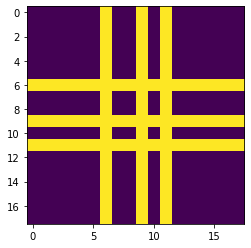

In [688]:
#image generation
img = np.zeros(shape=(height,width))

rr, cc, _ = line_aa(0, int(width*3/8), height-1, int(width*3/8))  
img[rr, cc] = 1

rr, cc, _ = line_aa(0, int(width/2), height-1, int(width/2))  
img[rr, cc] = 1

rr, cc, _ = line_aa(0, int(width*5/8), height-1, int(width*5/8))  
img[rr, cc] = 1

rr, cc, _ = line_aa(int(height*3/8), 0, int(height*3/8), width-1)  
img[rr, cc] = 1

rr, cc, _ = line_aa(int(height/2), 0, int(height/2), width-1)  
img[rr, cc] = 1

rr, cc, _ = line_aa(int(height*5/8), 0, int(height*5/8), width-1)  
img[rr, cc] = 1

plt.imshow(img)
plt.show()

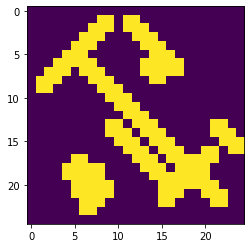

In [600]:
#image generation
img = np.zeros(shape=(height,width))

for i in range(5):
    #img[line_0(height, width)] = 1
    #img[line_90(height, width)] = 1
    img[line_45(height, width)] = 1
    img[line_135(height, width)] = 1

plt.imshow(img)
plt.show()

In [694]:
#applying convolutional filters
filtered = get_angles(img)
filtered[filtered != 2] = 0
filtered /= 2
filtered = filtered.reshape(-1)

length = 1000    # simulation time in ms
N = height * width * len(filters) # total number of neurons

#firings = np.zeros((length,N))
re = np.array(np.random.rand(N),dtype=np.double)  # uniformly distributed random doubles [0,1)
    
recov_scale = 0.02+0.001*re     # a = time scale of recovery
recov_sensitivity = 0.2+0.001*re     # b = sensitivity of recovery to subthreshold oscillations
voltage_reset = -65+5*(re**2)  # c = after-spike reset value of v
recov_reset = 8-6*(re**2)    # d = after-spike reset increment of u
voltage = -65.0 * np.ones(N,dtype=np.double) # Initial values of v
recov = recov_sensitivity*voltage    # Initial values of u
    
all_inp = np.zeros(shape=(N,))
#Itrace  = np.zeros(shape=(length, N))
decay = 0.1

voltage_out, recov_out, firings_out = simulate(recov_scale,
                                               recov_sensitivity,
                                               voltage_reset,
                                               recov_reset,
                                               voltage,
                                               recov,
                                               length,
                                               verbose=True)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Simulated 100ms of braintime in 0.13325130000157515s of computer time.
Simulated 200ms of braintime in 0.2688927999988664s of computer time.
Simulated 300ms of braintime in 0.3340410000018892s of computer time.
Simulated 400ms of braintime in 0.4505014000023948s of computer time.
Simulated 500ms of braintime in 0.5136080000011134s of computer time.
Simulated 600ms of braintime in 0.581617499999993s of computer time.
Simulated 700ms of braintime in 0.6637449999980163s of computer time.
Simulated 800ms of braintime in 0.738911200001894s of computer time.
Simulated 900ms of braintime in 0.7951093000010587s of computer time.
Simulation took 0.9181244999999763s


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [690]:
voltage_out1 = voltage_out.copy()
voltage_out1[voltage_out1 >= -30] = -30

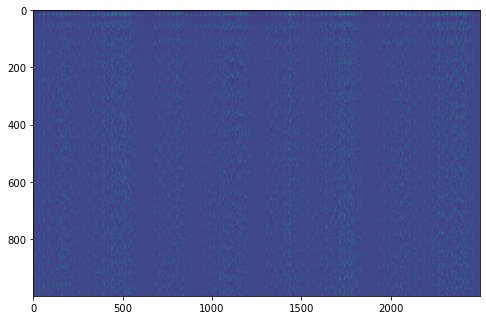

In [662]:
#OUTPUT FOR RANDOM DIAGONAL LINES

h, w = voltage_out1.shape #firings[:,1]

fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(voltage_out1.T)
#plt.imshow(firings_out.T)
#plt.colorbar()

ax.set_aspect(w*4/h)
plt.show()

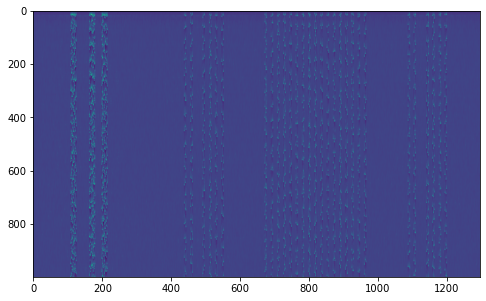

In [692]:
#OUTPUT FOR HORIZONTAL AND VERTICAL LINES

h, w = voltage_out1.shape #firings[:,1]

fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(voltage_out1.T) #firings[:]
#plt.colorbar()

ax.set_aspect(w/h)
plt.show()